# PixArt-α: Fast Training of Diffusion Transformer for Photorealistic Text-to-Image Synthesis with OpenVINO

[This paper](https://arxiv.org/abs/2310.00426) introduces [PIXART-α](https://github.com/PixArt-alpha/PixArt-alpha), a Transformer-based T2I diffusion model whose image generation quality is competitive with state-of-the-art image generators, reaching near-commercial application standards. Additionally, it supports high-resolution image synthesis up to 1024px resolution with low training cost. To achieve this goal, three core designs are proposed: 
1. Training strategy decomposition: We devise three distinct training steps that separately optimize pixel dependency, text-image alignment, and image aesthetic quality; 
2. Efficient T2I Transformer: We incorporate cross-attention modules into Diffusion Transformer (DiT) to inject text conditions and streamline the computation-intensive class-condition branch; 
3. High-informative data: We emphasize the significance of concept density in text-image pairs and leverage a large Vision-Language model to auto-label dense pseudo-captions to assist text-image alignment learning. 

![](https://huggingface.co/PixArt-alpha/PixArt-XL-2-1024-MS/resolve/main/asset/images/teaser.png)


#### Table of contents:
- [Prerequisites](#Prerequisites)
- [Load the original model](#Load-the-original-model)
- [Convert the model to OpenVINO IR](#Convert-the-model-to-OpenVINO-IR)
  - [Convert text encoder](#Convert-text-encoder)
  - [Convert transformer](#Convert-transformer)
  - [Convert VAE decoder](#Convert-VAE-decoder)
- [Compiling models](#Compiling-models)
- [Building the pipeline](#Building-the-pipeline)
- [Quantization](#Quantization)
    - [Prepare calibration dataset](#Prepare-calibration-dataset)
    - [Run quantization](#Run-quantization)
        - [Run Hybrid Quantization](#Run-Hybrid-Quantization)
        - [Run Weights Compression](#Run-Weights-Compression)
    - [Compare model file sizes](#Compare-model-file-sizes)
    - [Compare inference time of the FP16 and optimized pipelines](#Compare-inference-time-of-the-FP16-and-optimized-pipelines)
- [Interactive inference](#Interactive-inference)
### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/pixart/pixart.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
%pip install -q "diffusers>=0.14.0" sentencepiece "datasets>=2.14.6" "transformers>=4.25.1" "gradio>=4.19" "torch>=2.1" Pillow opencv-python --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -Uq "openvino>=2024.3.0"

In [2]:
import requests
from pathlib import Path


if not Path("pixart_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/pixart/pixart_helper.py")
    open("pixart_helper.py", "w").write(r.text)

if not Path("pixart_quantization_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/pixart/pixart_quantization_helper.py")
    open("pixart_quantization_helper.py", "w").write(r.text)

if not Path("notebook_utils.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )
    open("notebook_utils.py", "w").write(r.text)

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("pixart.ipynb")

## Load and run the original pipeline
[back to top ⬆️](#Table-of-contents:)

We use [PixArt-LCM-XL-2-1024-MS](https://huggingface.co/PixArt-alpha/PixArt-LCM-XL-2-1024-MS) that uses LCMs. [LCMs](https://arxiv.org/abs/2310.04378) is a diffusion distillation method which predict `PF-ODE's` solution directly in latent space, achieving super fast inference with few steps.

In [ ]:
import torch
from diffusers import PixArtAlphaPipeline


pipe = PixArtAlphaPipeline.from_pretrained("PixArt-alpha/PixArt-LCM-XL-2-1024-MS", use_safetensors=True)

prompt = "A small cactus with a happy face in the Sahara desert."
generator = torch.Generator().manual_seed(42)

image = pipe(prompt, guidance_scale=0.0, num_inference_steps=4, generator=generator).images[0]

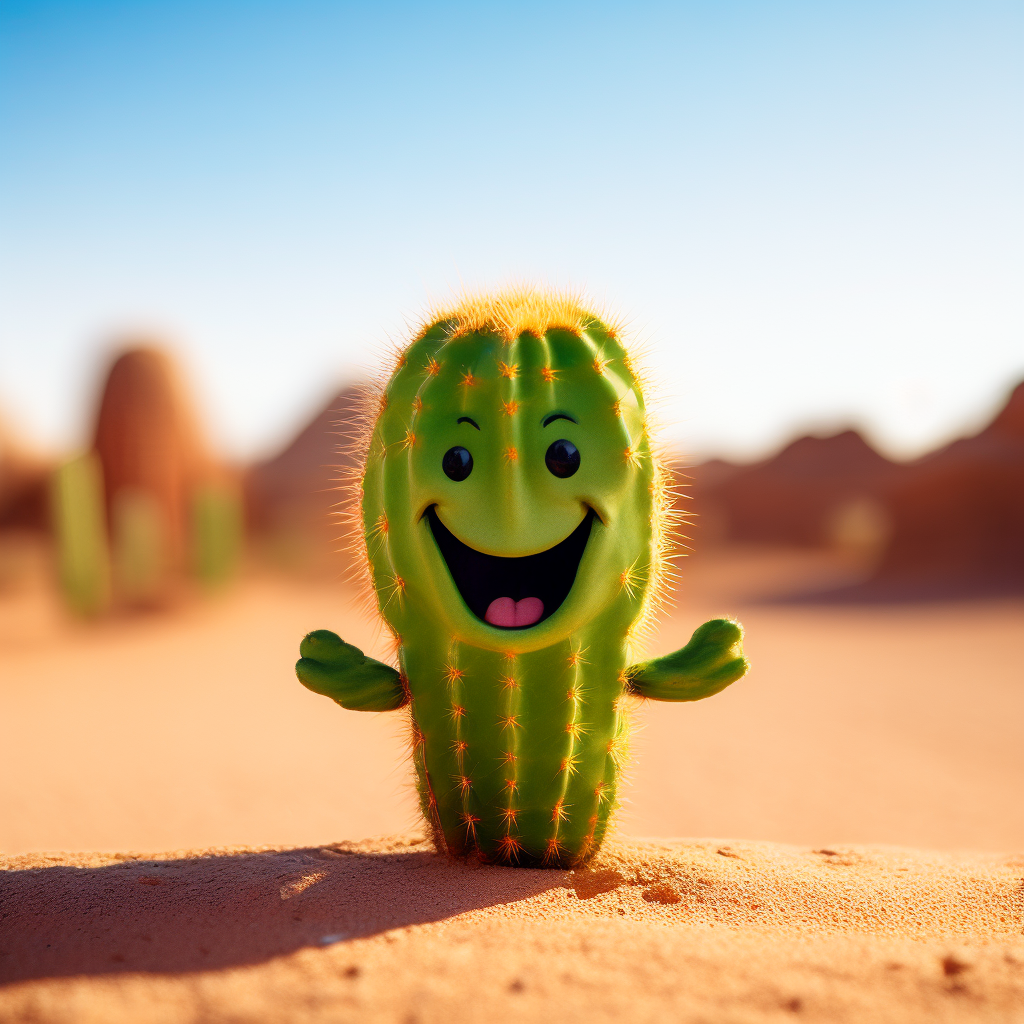

In [4]:
image

## Convert the model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

Let's define the conversion function for PyTorch modules. We use `ov.convert_model` function to obtain OpenVINO Intermediate Representation object and `ov.save_model` function to save it as XML file.

In [5]:
import torch
import openvino as ov


def convert(model: torch.nn.Module, xml_path: str, example_input):
    xml_path = Path(xml_path)
    if not xml_path.exists():
        xml_path.parent.mkdir(parents=True, exist_ok=True)
        model.eval()
        with torch.no_grad():
            converted_model = ov.convert_model(model, example_input=example_input)
        ov.save_model(converted_model, xml_path)

        # cleanup memory
        torch._C._jit_clear_class_registry()
        torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
        torch.jit._state._clear_class_state()

PixArt-α consists of pure transformer blocks for latent diffusion: It can directly generate 1024px images from text prompts within a single sampling process.

![](https://huggingface.co/PixArt-alpha/PixArt-XL-2-1024-MS/resolve/main/asset/images/model.png).

During inference it uses text encoder `T5EncoderModel`, transformer `Transformer2DModel` and VAE decoder `AutoencoderKL`. Let's convert the models from the pipeline one by one.

In [6]:
from pixart_helper import TEXT_ENCODER_PATH, TRANSFORMER_OV_PATH, VAE_DECODER_PATH

### Convert text encoder
[back to top ⬆️](#Table-of-contents:)

In [7]:
example_input = {
    "input_ids": torch.zeros(1, 120, dtype=torch.int64),
    "attention_mask": torch.zeros(1, 120, dtype=torch.int64),
}

convert(pipe.text_encoder, TEXT_ENCODER_PATH, example_input)

### Convert transformer
[back to top ⬆️](#Table-of-contents:)

In [8]:
class TransformerWrapper(torch.nn.Module):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer

    def forward(self, hidden_states=None, timestep=None, encoder_hidden_states=None, encoder_attention_mask=None, resolution=None, aspect_ratio=None):
        return self.transformer.forward(
            hidden_states,
            timestep=timestep,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            added_cond_kwargs={"resolution": resolution, "aspect_ratio": aspect_ratio},
        )


example_input = {
    "hidden_states": torch.rand([2, 4, 128, 128], dtype=torch.float32),
    "timestep": torch.tensor([999, 999]),
    "encoder_hidden_states": torch.rand([2, 120, 4096], dtype=torch.float32),
    "encoder_attention_mask": torch.rand([2, 120], dtype=torch.float32),
    "resolution": torch.tensor([[1024.0, 1024.0], [1024.0, 1024.0]]),
    "aspect_ratio": torch.tensor([[1.0], [1.0]]),
}


w_transformer = TransformerWrapper(pipe.transformer)
convert(w_transformer, TRANSFORMER_OV_PATH, example_input)

### Convert VAE decoder
[back to top ⬆️](#Table-of-contents:)

In [9]:
class VAEDecoderWrapper(torch.nn.Module):
    def __init__(self, vae):
        super().__init__()
        self.vae = vae

    def forward(self, latents):
        return self.vae.decode(latents, return_dict=False)


convert(VAEDecoderWrapper(pipe.vae), VAE_DECODER_PATH, (torch.zeros((1, 4, 128, 128))))

## Compiling models
[back to top ⬆️](#Table-of-contents:)

Select device from dropdown list for running inference using OpenVINO.

In [10]:
from notebook_utils import device_widget

device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [11]:
core = ov.Core()

compiled_model = core.compile_model(TRANSFORMER_OV_PATH, device.value)
compiled_vae = core.compile_model(VAE_DECODER_PATH, device.value)
compiled_text_encoder = core.compile_model(TEXT_ENCODER_PATH, device.value)

## Building the pipeline
[back to top ⬆️](#Table-of-contents:)

Let's create callable wrapper classes for compiled models to allow interaction with original pipelines. Note that all of wrapper classes return `torch.Tensor`s instead of `np.array`s.

In [12]:
from collections import namedtuple

EncoderOutput = namedtuple("EncoderOutput", "last_hidden_state")


class TextEncoderWrapper(torch.nn.Module):
    def __init__(self, text_encoder, dtype):
        super().__init__()
        self.text_encoder = text_encoder
        self.dtype = dtype

    def forward(self, input_ids=None, attention_mask=None):
        inputs = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
        }
        last_hidden_state = self.text_encoder(inputs)[0]
        return EncoderOutput(torch.from_numpy(last_hidden_state))

In [13]:
class TransformerWrapper(torch.nn.Module):
    def __init__(self, transformer, config):
        super().__init__()
        self.transformer = transformer
        self.config = config

    def forward(
        self,
        hidden_states=None,
        timestep=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        resolution=None,
        aspect_ratio=None,
        added_cond_kwargs=None,
        **kwargs
    ):
        inputs = {
            "hidden_states": hidden_states,
            "timestep": timestep,
            "encoder_hidden_states": encoder_hidden_states,
            "encoder_attention_mask": encoder_attention_mask,
        }
        resolution = added_cond_kwargs["resolution"]
        aspect_ratio = added_cond_kwargs["aspect_ratio"]
        if resolution is not None:
            inputs["resolution"] = resolution
            inputs["aspect_ratio"] = aspect_ratio
        outputs = self.transformer(inputs)[0]

        return [torch.from_numpy(outputs)]

In [14]:
class VAEWrapper(torch.nn.Module):
    def __init__(self, vae, config):
        super().__init__()
        self.vae = vae
        self.config = config

    def decode(self, latents=None, **kwargs):
        inputs = {
            "latents": latents,
        }

        outs = self.vae(inputs)
        outs = namedtuple("VAE", "sample")(torch.from_numpy(outs[0]))

        return outs

And insert wrappers instances in the pipeline:

In [15]:
pipe.__dict__["_internal_dict"]["_execution_device"] = pipe._execution_device  # this is to avoid some problem that can occur in the pipeline

pipe.register_modules(
    text_encoder=TextEncoderWrapper(compiled_text_encoder, pipe.text_encoder.dtype),
    transformer=TransformerWrapper(compiled_model, pipe.transformer.config),
    vae=VAEWrapper(compiled_vae, pipe.vae.config),
)

In [ ]:
generator = torch.Generator().manual_seed(42)

image = pipe(prompt=prompt, guidance_scale=0.0, num_inference_steps=4, generator=generator).images[0]

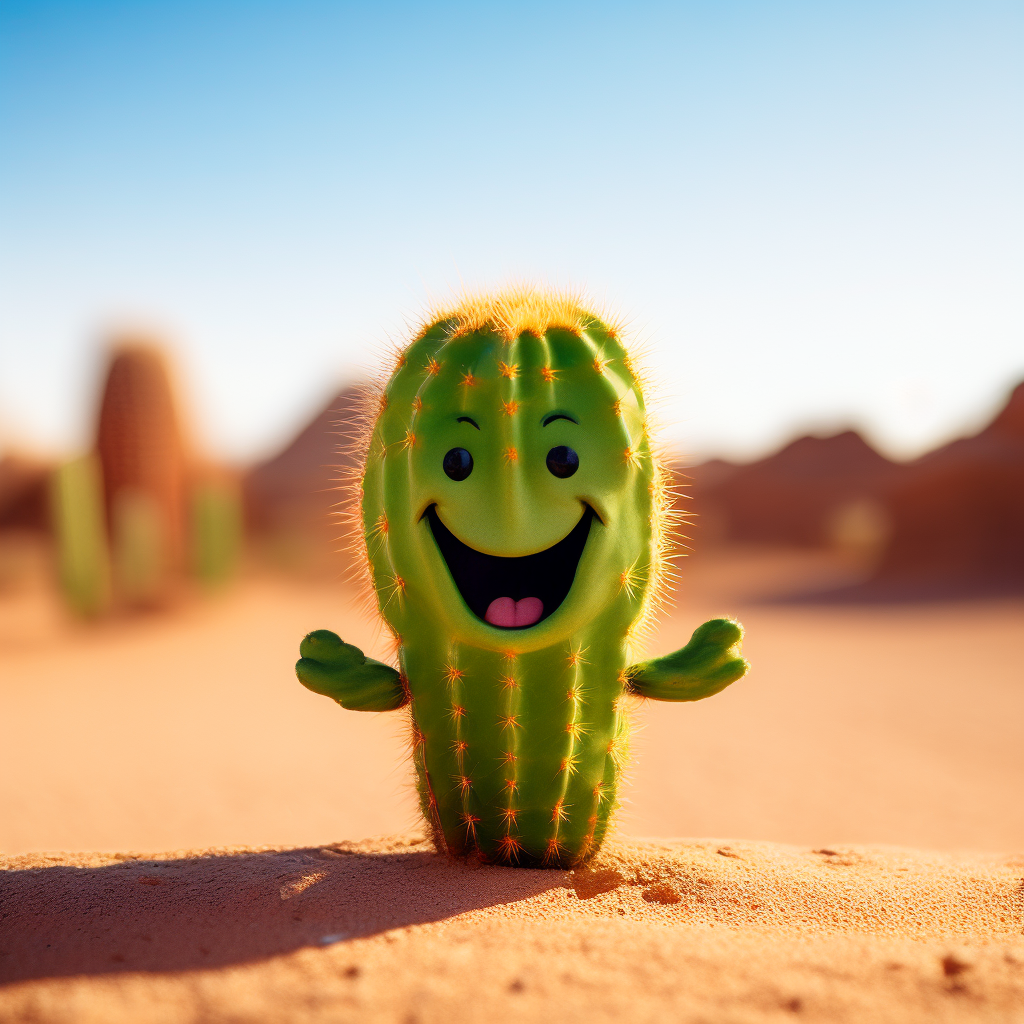

In [17]:
image

## Quantization
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.

According to `PixArt-LCM-XL-2-1024-MS` structure, `Transformer2DModel` is used in the cycle repeating inference on each diffusion step, while other parts of pipeline take part only once. Quantizing the rest of the pipeline does not significantly improve inference performance but can lead to a substantial degradation of accuracy. That's why we use only weight compression in 4-bits for the `text encoder` and `vae decoder` to reduce the memory footprint.
Now we will show you how to optimize pipeline using [NNCF](https://github.com/openvinotoolkit/nncf/) to reduce memory and computation cost.

Please select below whether you would like to run quantization to improve model inference speed.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take some time.

In [ ]:
from notebook_utils import quantization_widget

to_quantize = quantization_widget()

to_quantize

Let's load `skip magic` extension to skip quantization if `to_quantize` is not selected

In [19]:
# Fetch `skip_kernel_extension` module
if not Path("skip_kernel_extension.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
    )
    open("skip_kernel_extension.py", "w").write(r.text)

optimized_pipe = None

%load_ext skip_kernel_extension

### Prepare calibration dataset
[back to top ⬆️](#Table-of-contents:)

We use a portion of [`google-research-datasets/conceptual_captions`](https://huggingface.co/datasets/google-research-datasets/conceptual_captions) dataset from Hugging Face as calibration data. We use prompts below to guide image generation and to determine what not to include in the resulting image.

To collect intermediate model inputs for calibration we should customize `CompiledModel`.

In [20]:
%%skip not $to_quantize.value

from pixart_quantization_helper import INT8_TRANSFORMER_OV_PATH, INT4_TEXT_ENCODER_PATH, INT4_VAE_DECODER_PATH, collect_calibration_data

if not INT8_TRANSFORMER_OV_PATH.exists():
    subset_size = 100
    calibration_data = collect_calibration_data(pipe, subset_size=subset_size)

### Run Hybrid Quantization
[back to top ⬆️](#Table-of-contents:)

For the `Transformer2DModel` model we apply quantization in hybrid mode which means that we quantize: (1) weights of MatMul and Embedding layers and (2) activations of other layers. The steps are the following:

1. Create a calibration dataset for quantization.
2. Collect operations with weights.
3. Run nncf.compress_model() to compress only the model weights.
4. Run nncf.quantize() on the compressed model with weighted operations ignored by providing ignored_scope parameter.
5. Save the INT8 model using openvino.save_model() function.

In [21]:
%%skip not $to_quantize.value

import nncf
from nncf.quantization.advanced_parameters import AdvancedSmoothQuantParameters
from nncf.quantization.advanced_parameters import AdvancedQuantizationParameters
from pixart_quantization_helper import get_quantization_ignored_scope

if not INT8_TRANSFORMER_OV_PATH.exists():
    model = core.read_model(TRANSFORMER_OV_PATH)
    ignored_scope = get_quantization_ignored_scope(model)
    # The convolution operations will be fully quantized
    compressed_model = nncf.compress_weights(model, ignored_scope=nncf.IgnoredScope(types=['Convolution']))
    quantized_model = nncf.quantize(
        model=compressed_model,
        calibration_dataset=nncf.Dataset(calibration_data),
        subset_size=subset_size,
        ignored_scope=nncf.IgnoredScope(names=ignored_scope),
        model_type=nncf.ModelType.TRANSFORMER,
        # Disable SQ because MatMul weights are already compressed
        advanced_parameters=AdvancedQuantizationParameters(smooth_quant_alphas=AdvancedSmoothQuantParameters(matmul=-1))
    )
    ov.save_model(quantized_model, INT8_TRANSFORMER_OV_PATH)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


### Run Weights Compression
[back to top ⬆️](#Table-of-contents:)

Quantizing of the `T5EncoderModel` and `AutoencoderKL` does not significantly improve inference performance but can lead to a substantial degradation of accuracy. The weight compression will be applied to footprint reduction.

In [22]:
%%skip not $to_quantize.value

if not INT4_TEXT_ENCODER_PATH.exists():
    text_encoder = core.read_model(TEXT_ENCODER_PATH)
    compressed_text_encoder = nncf.compress_weights(text_encoder, mode=nncf.CompressWeightsMode.INT4_SYM)
    ov.save_model(compressed_text_encoder, INT4_TEXT_ENCODER_PATH)

if not INT4_VAE_DECODER_PATH.exists():
    vae_decoder = core.read_model(VAE_DECODER_PATH)
    compressed_vae_decoder = nncf.compress_weights(vae_decoder, mode=nncf.CompressWeightsMode.INT4_SYM)
    ov.save_model(compressed_vae_decoder, INT4_VAE_DECODER_PATH)

Let's compare the images generated by the original and optimized pipelines.

In [ ]:
%%skip not $to_quantize.value

# Disable dynamic quantization due to the performance overhead for Diffusion models
optimized_transformer = core.compile_model(INT8_TRANSFORMER_OV_PATH, device.value, config={"DYNAMIC_QUANTIZATION_GROUP_SIZE":"0"})
optimized_text_encoder = core.compile_model(INT4_TEXT_ENCODER_PATH, device.value)
optimized_vae_decoder = core.compile_model(INT4_VAE_DECODER_PATH, device.value)

optimized_pipe = PixArtAlphaPipeline.from_pretrained("PixArt-alpha/PixArt-LCM-XL-2-1024-MS", use_safetensors=True)
optimized_pipe.__dict__["_internal_dict"]["_execution_device"] = optimized_pipe._execution_device  # this is to avoid some problem that can occur in the pipeline

optimized_pipe.register_modules(
    text_encoder=TextEncoderWrapper(optimized_text_encoder, optimized_pipe.text_encoder.dtype),
    transformer=TransformerWrapper(optimized_transformer, optimized_pipe.transformer.config),
    vae=VAEWrapper(optimized_vae_decoder, optimized_pipe.vae.config),
)

/home/ltalamanova/tmp_venv/lib/python3.11/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `_execution_device` directly via 'PixArtAlphaPipeline' object attribute is deprecated. Please access '_execution_device' over 'PixArtAlphaPipeline's config object instead, e.g. 'scheduler.config._execution_device'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/4 [00:00<?, ?it/s]

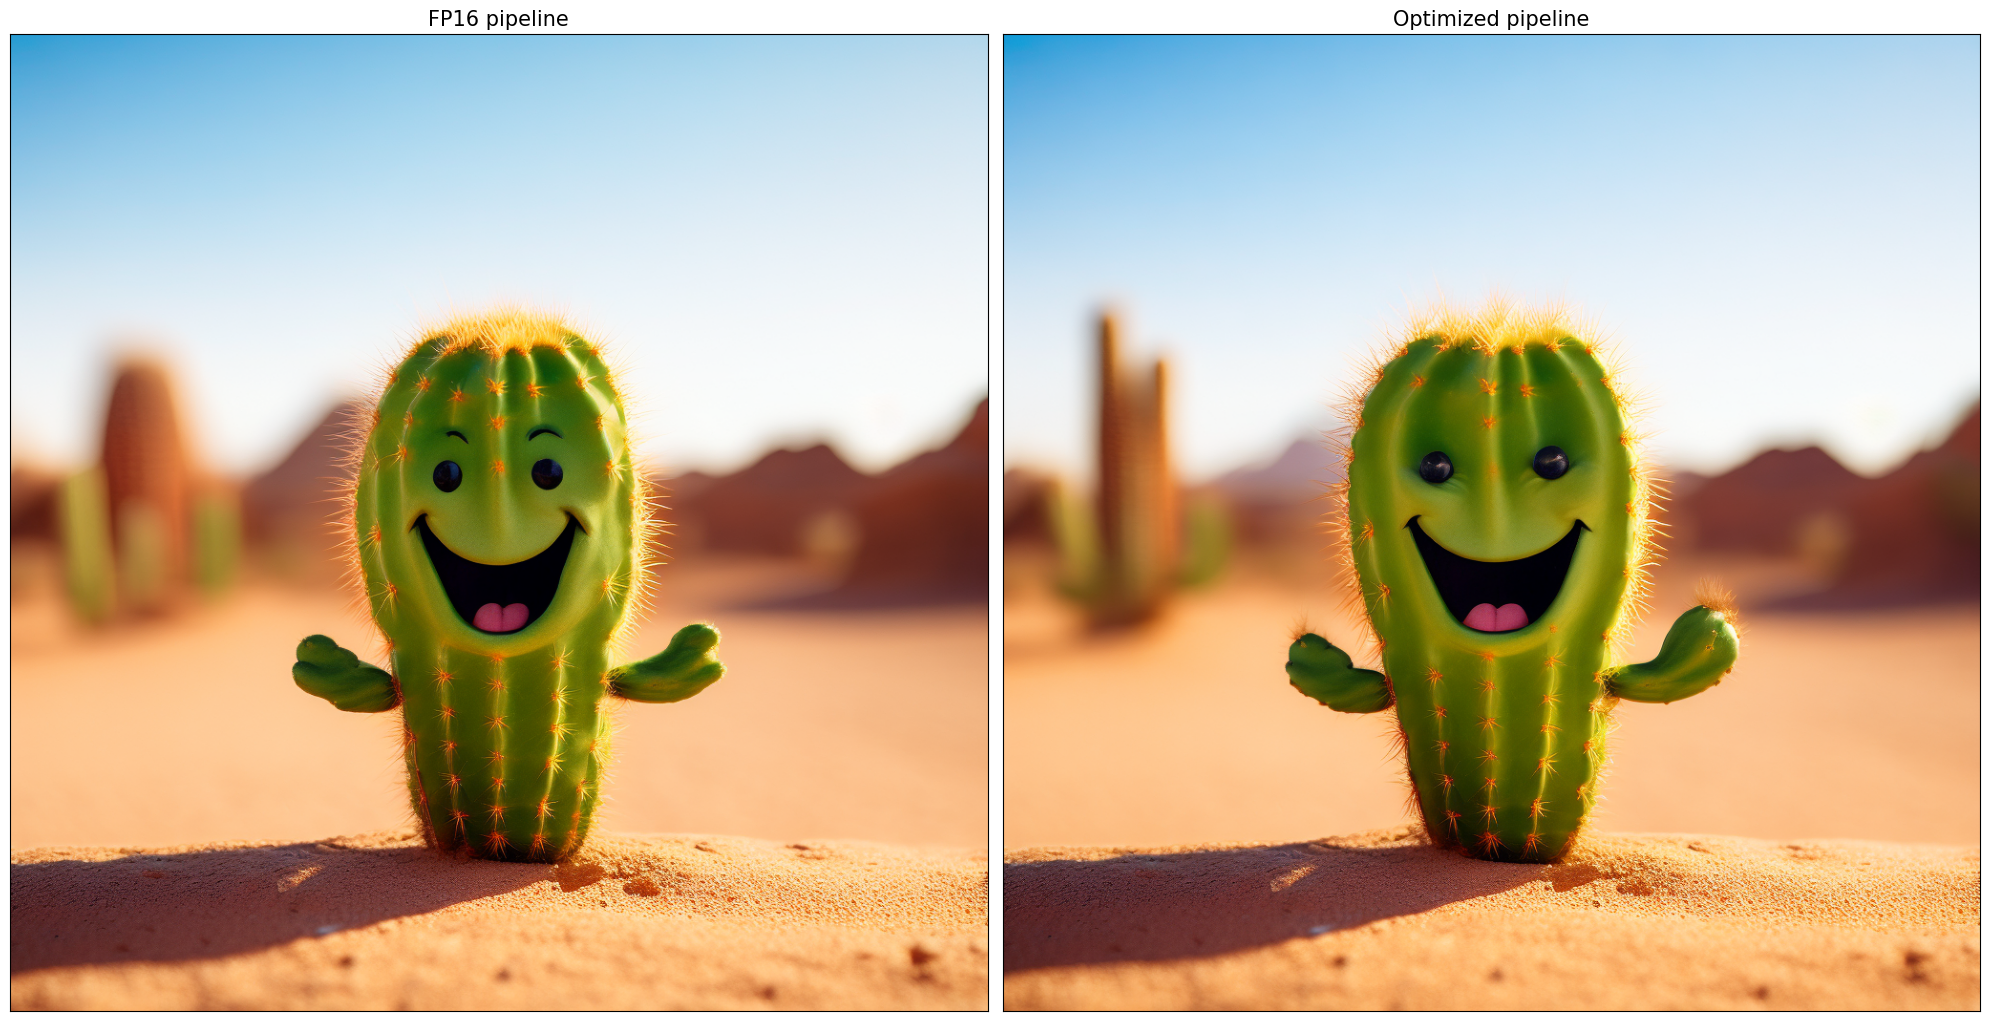

In [25]:
%%skip not $to_quantize.value

from pixart_quantization_helper import visualize_results

prompt = "A small cactus with a happy face in the Sahara desert."
generator = torch.Generator().manual_seed(42)
opt_image = optimized_pipe(prompt=prompt, guidance_scale=0.0, num_inference_steps=4, generator=generator).images[0]

visualize_results(image, opt_image)

### Compare model file sizes
[back to top ⬆️](#Table-of-contents:)

In [26]:
%%skip not $to_quantize.value
from pixart_quantization_helper import compare_models_size

compare_models_size()

transformer_ir compression rate: 1.979
text_encoder compression rate: 4.514
vae_decoder compression rate: 2.012


### Compare inference time of the FP16 and optimized pipelines
[back to top ⬆️](#Table-of-contents:)

To measure the inference performance of the `FP16` and optimized pipelines, we use mean inference time on 3 samples.

> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications.

In [27]:
%%skip not $to_quantize.value

from pixart_quantization_helper import compare_perf

compare_perf(pipe, optimized_pipe, validation_size=3)

/home/ltalamanova/tmp_venv/lib/python3.11/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `_execution_device` directly via 'PixArtAlphaPipeline' object attribute is deprecated. Please access '_execution_device' over 'PixArtAlphaPipeline's config object instead, e.g. 'scheduler.config._execution_device'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


FP16 pipeline: 30.932 seconds
Optimized pipeline: 30.546 seconds
Performance speed-up: 1.013


## Interactive inference
[back to top ⬆️](#Table-of-contents:)

Please select below whether you would like to use the quantized models to launch the interactive demo.

In [ ]:
from pixart_helper import get_pipeline_selection_option

use_quantized_models = get_pipeline_selection_option(optimized_pipe)

use_quantized_models

In [ ]:
pipeline = optimized_pipe if use_quantized_models.value else pipe


def generate(prompt, seed, negative_prompt, num_inference_steps):
    generator = torch.Generator().manual_seed(seed)
    image = pipeline(prompt=prompt, negative_prompt=negative_prompt, num_inference_steps=num_inference_steps, generator=generator, guidance_scale=0.0).images[0]
    return image


if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/pixart/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo

demo = make_demo(fn=generate)

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(debug=True, share=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/